# Indian Food Classification using Tensorflow (CNN Transfer learning)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Dependencies
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
from PIL import Image
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from skimage.io import imread

K.clear_session()

## Challenges

**1. Cleaning the dataset due to following :**
- A lot of misspelled labels.
- Overwhelming number of raw images not related to any class.

**2. Training model without bias :**
- Similarly looking items with common attributes (Fried samosa and pakode looks familiar.)
- Multiple labels clashing together (Butter Naan and Dal Makhni in one picture, Samosa and Pakode, etc.)
- Unwanted feature selection because of big architectures in transfer learning (Ketchup and green chutney is most common thing alongside pakode, samosa, kathi rolls and what not.)

## IMAGE PROCESSSING
Let's understand the Data and Do some Stuffs

In [4]:
img = plt.imread('/content/drive/MyDrive/food classification/dataset/Dataset/train/burger/001.jpg')
dims = np.shape(img)
dims

(3456, 3456, 3)

In [5]:
matrix = np.reshape(img , (dims[0] * dims[1] , dims[2]))
print(np.shape(matrix))

(11943936, 3)


Image Shape:- (3456, 3456)
Color Channels:- 3
Min Color Depth : 0, Max Color Depth 255


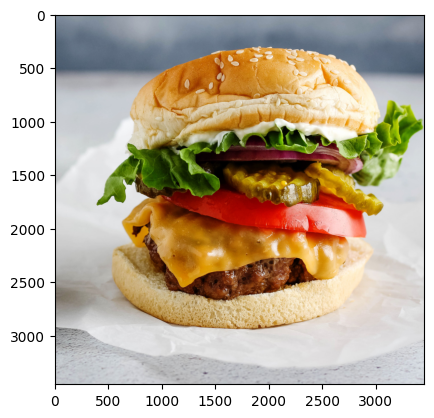

In [6]:
plt.imshow(img)
print("Image Shape:-" , dims[:2])
print("Color Channels:-", dims[2])
print("Min Color Depth : {}, Max Color Depth {}".format(np.min(img) , np.max(img)))

Plot for visualizing pixel intensities for RGB in color space


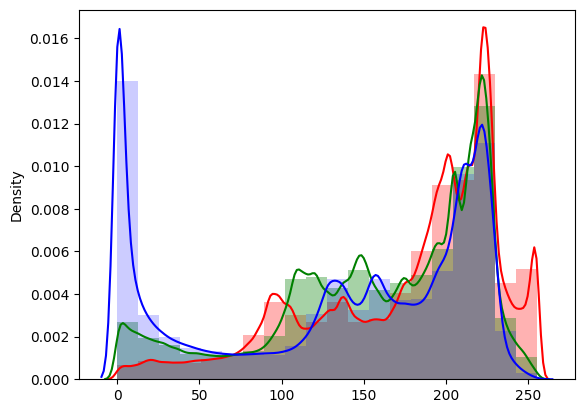

In [7]:
sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="blue",hist_kws=dict(alpha=0.2))
plt.show()

Plot for visualizing histogram between 2 color channel

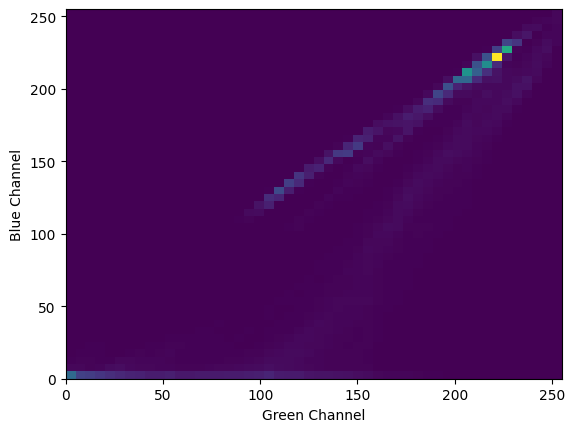

In [8]:
_ = plt.hist2d(matrix[:,1] , matrix[:,2] , bins = (50,50))
plt.xlabel("Green Channel")
plt.ylabel("Blue Channel")
plt.show()

 - The pixels between green and blue bands are correlated (as evident from overlapping on above graph), and typically has visible imagery.

 - Raw band differences will need to be scaled or thresholded

Image data consists of variations due to resolution differences between scenes,
pixel intensities of an image and the environment around which the image was taken.
This area of image processing is critical in today's time with the rise of Artificial
intelligence.From motion detection to complex circuits in self driving car,
the research requires tremendous amount of work and can be seen as widely growing areas of computer vision.

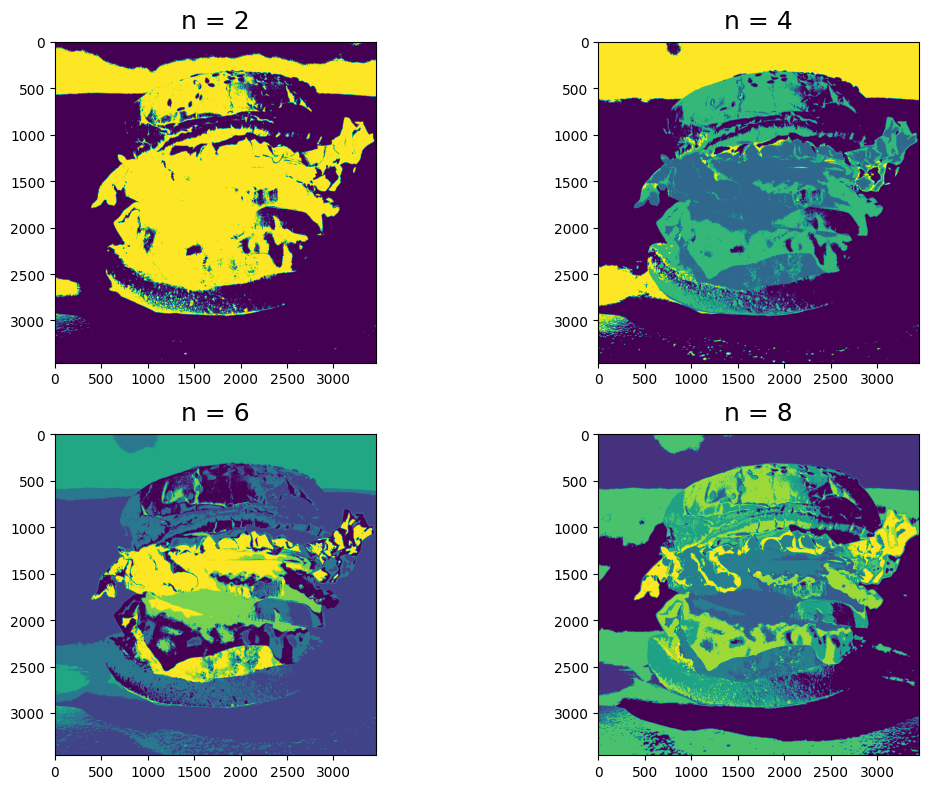

In [9]:
from sklearn import cluster
n_vals = [2,4,6,8]
plt.figure(1 , figsize = (12 , 8))

for subplot , n in enumerate(n_vals):
    kmeans = cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    dims = np.shape(img)
    clustered_img = np.reshape(clustered , (dims[0] , dims[1]))
    plt.subplot(2,2, subplot+1)
    plt.title("n = {}".format(n) , pad = 10 , size = 18)
    plt.imshow(clustered_img)

plt.tight_layout()

# Exploratory Data Analysis (EDA)
Let's visualize number of training examples for each food item

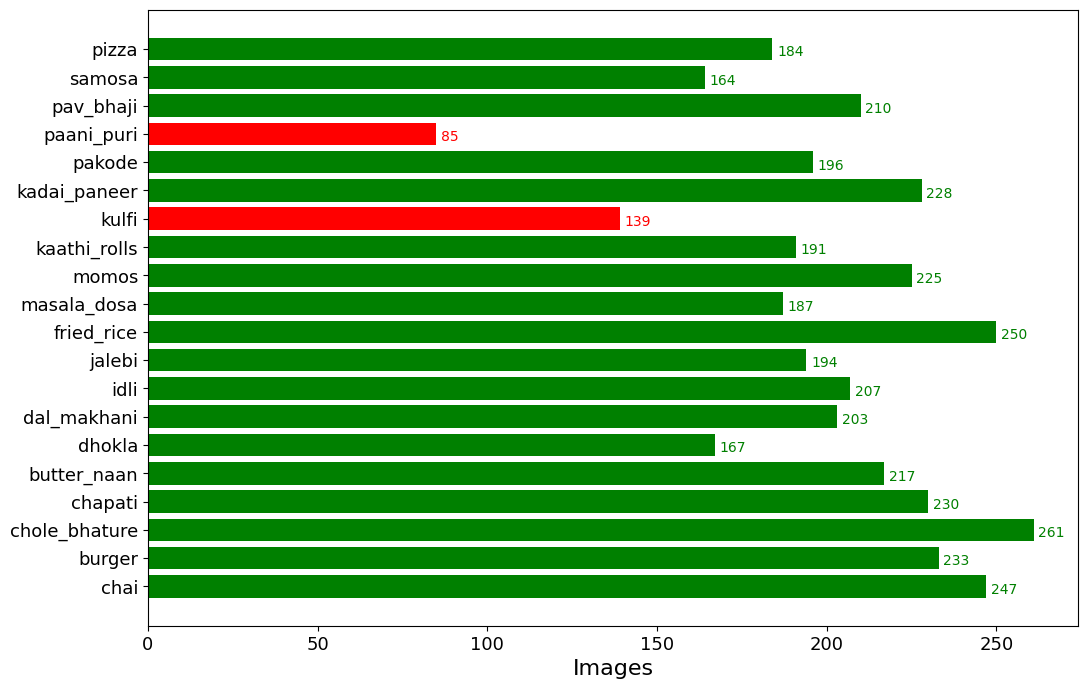

In [10]:
import os

train = '/content/drive/MyDrive/food classification/dataset/Dataset/train'

data = dict()

for i in os.listdir(train):
    sub_dir = os.path.join(train , i)
    count = len(os.listdir(sub_dir))
    data[i] = count

keys = data.keys()
values = data.values()

colors = ["red" if x<= 150 else "green" for x in values]

fig , ax = plt.subplots(figsize = (12,8))
y_pos = np.arange(len(values))
plt.barh(y_pos , values , align = "center" , color=colors)
for i , v in enumerate(values):
    ax.text(v+1.4 , i-0.25 , str(v), color = colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()


**We notice that 2 classes (Pani puri and Kulfi) lacks behind with training data.**
 - Data augmentation helps with classes not having enough training
   examples by increasing the amount of relevant data in the dataset.

 - We would be doing what is known as **offline augmentation**.
    It works on relatively smaller datasets, by increasing the
    size of the dataset by a factor equal to the number of transformations you perform.
    (For example, by flipping all my images, it would increase the size of the dataset by a factor of 2).

Let's visualize our dataset by randomly picking an image from every class

In [ ]:
import random

train_folder = "/content/drive/MyDrive/food classification/dataset/Dataset/train"
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + "/" + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder , food_folder , food_selected))


fig = plt.figure(1 , figsize = (25,25))
for subplot , image_ in enumerate(images):
    category = image_.split("/")[-2]
    imgs = plt.imread(image_)
    a ,b, c = imgs.shape
    fig = plt.subplot(5 , 4 , subplot+1)
    fig.set_title(category , pad = 10 , size = 18)
    plt.imshow(imgs)

plt.tight_layout()

We discussed Data Augmentation before. Let's see how it works:
1. Accepting a batch of images used for training.

2. Taking this batch and applying a series of random transformations to each image in the batch. (including random rotation, resizing, shearing, etc.)

3. Replacing the original batch with the new, randomly transformed batch.

4. Training the CNN on this randomly transformed batch. (i.e, the original data itself is not used for training)

## Model Training and Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 20
batch_size = 32
img_width , img_height = 299 , 299

train_data_dir = '/content/drive/MyDrive/food classification/dataset/Dataset/train'

# Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)


val_data_dir = '/content/drive/MyDrive/food classification/dataset/Dataset/val'
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 4018 images belonging to 20 classes.
Found 1250 images belonging to 20 classes.


In [ ]:
class_map = train_generator.class_indices
class_map

{'burger': 0,
 'butter_naan': 1,
 'chai': 2,
 'chapati': 3,
 'chole_bhature': 4,
 'dal_makhani': 5,
 'dhokla': 6,
 'fried_rice': 7,
 'idli': 8,
 'jalebi': 9,
 'kaathi_rolls': 10,
 'kadai_paneer': 11,
 'kulfi': 12,
 'masala_dosa': 13,
 'momos': 14,
 'paani_puri': 15,
 'pakode': 16,
 'pav_bhaji': 17,
 'pizza': 18,
 'samosa': 19}

## Training the model


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

nb_train_samples = 3583
nb_valid_samples = 1089

image_size = [299 , 299]

inception = InceptionV3(input_shape = image_size + [3] , weights = "imagenet" , include_top = False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128 , activation = "relu")(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes , kernel_regularizer = l2(0.005) , activation = "softmax")(x)

model = Model(inputs = inception.input , outputs = predictions)
model.compile(optimizer = SGD(lr=0.0001 , momentum = 0.9) , loss = "categorical_crossentropy" , metrics = ["accuracy"])

checkpoints = ModelCheckpoint(filepath = "v1_inceptionV3" , verbose = 1 , save_best_only = True)
csv_logger = CSVLogger("history_v1_inceptionV3.log")

history = model.fit_generator(train_generator,
                             steps_per_epoch = nb_train_samples // batch_size,
                             validation_data = val_generator,
                             validation_steps = nb_valid_samples // batch_size,
                             epochs = 20,
                             verbose = 1,
                             callbacks = [csv_logger , checkpoints])
# Save the model
model.save("/content/drive/MyDrive/model/model_inceptionV3.h5")

In [ ]:
## Accuracy and Loss Curves

def plot_accuracy(history):

    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):

    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

plot_accuracy(history)
plot_loss(history)


## Prediction

In [ ]:
# load the model
K.clear_session()
model_path = "./model_inceptionV3.h5"
print("loading the model..")
model = load_model(model_path)
print("Done!")

## Testing Model on Test Set

In [ ]:
test_data_dir = '/content/drive/MyDrive/food classification/test'

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                 target_size = (img_height , img_width),
                                                 batch_size = batch_size,
                                                 class_mode = "categorical")

In [ ]:
scores = model.evaluate_generator(test_generator)
print("Test Accuracy : {:.3f}".format(scores[1]))

In [ ]:
# Function to predict single image or predict all images from a directory
category={
    0: ['burger','Burger'], 1: ['butter_naan','Butter Naan'], 2: ['chai','Chai'],
    3: ['chapati','Chapati'], 4: ['chole_bhature','Chole Bhature'], 5: ['dal_makhani','Dal Makhani'],
    6: ['dhokla','Dhokla'], 7: ['fried_rice','Fried Rice'], 8: ['idli','Idli'], 9: ['jalegi','Jalebi'],
    10: ['kathi_rolls','Kaathi Rolls'], 11: ['kadai_paneer','Kadai Paneer'], 12: ['kulfi','Kulfi'],
    13: ['masala_dosa','Masala Dosa'], 14: ['momos','Momos'], 15: ['paani_puri','Paani Puri'],
    16: ['pakode','Pakode'], 17: ['pav_bhaji','Pav Bhaji'], 18: ['pizza','Pizza'], 19: ['samosa','Samosa']
}

def predict_image(filename , model):
    img_ = image.load_img(filename , target_size = (299,299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array , axis = 0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index][1]))
    plt.imshow(img_array)

predict_image('/content/drive/MyDrive/food classification/test/dal_makhani/download (1).jpg' , model)

In [ ]:
def predict_images(filenames , model):
    cols = 5
    pos = 0
    images = []
    total_images = len(os.listdir(filenames))
    rows = total_images // cols + 1

    true = filenames.split("/")[-1]
    fig = plt.figure(1 , figsize = (25,25))

    for i in sorted(os.listdir(filenames)):
        images.append(os.path.join(filenames , i))

    for subplot , imgs in enumerate(images):
        img_ = image.load_img(imgs , target_size = (299 , 299))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array , axis = 0)
        img_processed /= 255.

        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        preds = category.get(index)[0]
        if preds == true:
            pos+=1

        fig = plt.subplot(rows , cols , subplot+1)
        fig.set_title(category.get(index)[1] , pad = 10 , size = 18)
        plt.imshow(img_array)

    acc = pos/total_images
    print("Accuracy of Test : {:.2f} ({pos} / {total})".format(acc , pos = pos , total = total_images))
    plt.tight_layout()

predict_images("/content/drive/MyDrive/food classification/test/chai",model)

## Let's plot a confusion matrix for all the food items

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

img_width, img_height = 299, 299

def labels_confusion_matrix():
    folder_path="/content/drive/MyDrive/food classification/test/chai"

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(img_height, img_width))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):

    cmap="viridis"
    cm_plot_labels = [i for i in range(20)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.1) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm, annot=True,cmap=cmap) # font size
#     bottom,top=s.get_ylim()
#     s.set_ylim(bottom+0.6,top-0.6)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()


In [ ]:
y_true,y_pred=labels_confusion_matrix()
print_confusion_matrix(y_true,y_pred)

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/food classification/test/chai/download (1).jpg'